# Sales Predictions using Time Series Data
* https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data

## Overview of Problem

"You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge." *(src: competition page)*

## Imports

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Load Data 
* The data provided from the Kaggle competition was edited and saved
* This notebook will load the updated file and continue from there

In [2]:
# Load the data

In [2]:
dfSales = pd.read_csv("dfShopItemsFull.csv")

## Quick Stats on the data
dfSales.info()

There are not any null values, but the instructions mention that there are holes in data for stores and items within some months. I am going to transform the data into a dataframe with item and store as the key and the sums for each month in the columns. 

In [4]:
dfSales.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


Much of the text of the data is in Russian. This is not really relevant because we do not need to look at item descriptions and category names. We can work with just IDs. I don't see any need to load the item and shops files unless I want to include item descriptions in my report.

## Supervised Learning
### LSTM Artificial Neural Network with Linear Activation
* The Long Short Term Memory Neural Network is a good option for time sequence data
* To use this model we needed to align a lookback so that the model is trained using the data for the next time period as the result from the current
* In a single variable time series problem, we can just look at the next record
* In our problem we have a combination of items and stores so we need to have a lookback offset of items * stores
* Some models will look forward by more than one timeslot, but due to computational and time restrictions we looked ahead by a single month
* Similarly, we restricted our model to 2 LSTM layers and 1 dense layer
* Results would have been improved with a deeper model but time constraints necessitated a simple model


#### Scale the Data
* The data must be scaled to use an LSTM Neural Network

In [5]:
#training_labels = dfSales['item_cnt_month']

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
dfScaled = pd.DataFrame(scaler.fit_transform(dfSales[['date_block_num','shop_id','item_id','item_cnt_month']]),
                                           columns= ['date_block_num','shop_id','item_id','item_cnt_month'])

In [10]:
dfScaled 

,date_block_num,shop_id,item_id,item_cnt_month
0,0.0,0.000000,0.001443,0.022152
1,0.0,0.000000,0.001489,0.019778
2,0.0,0.000000,0.001579,0.018196
3,0.0,0.000000,0.001940,0.018196
4,0.0,0.000000,0.002301,0.018987
...,...,...,...,...
44443435,1.0,0.610169,0.574361,0.017405
44443436,1.0,0.610169,0.590554,0.017405
44443437,1.0,0.610169,0.757680,0.017405
44443438,1.0,0.610169,0.814651,0.017405


In [11]:
# The orginal dataframe takes 1.3 GB of memory
# I am going to remove the original dataset due to memory constraints
del dfSales

#### Test and Train Data Split

In [ ]:
# Break the dataset into test and training
# traning with everything except the last month and test with that

In [8]:
last_month_size = dfScaled[dfScaled['date_block_num'].astype(int)==1].shape[0]

In [46]:
#X_test = dfScaled.iloc[-last_month_size:]

In [48]:
#X_train = dfScaled.iloc[:-last_month_size]

In [50]:
#y_train = training_labels[:-last_month_size]

In [51]:
#y_test = training_labels[-last_month_size:]

#### Model 
* We tested a few different model configurations
* Some of them either took too long to train or resulted in too high loss
* For the purposes of brevity, we are only showing one model in this notebook


In [12]:
last_month_size = dfScaled[dfScaled['date_block_num'].astype(int)==1].shape[0]

In [13]:
trainx = np.array(dfScaled.iloc[:-last_month_size,:].reset_index().drop(['index'],axis=1))
trainy = dfScaled.iloc[last_month_size:,:]['item_cnt_month'].reset_index().drop(['index'],axis=1)

In [14]:
trainy

,item_cnt_month
0,0.025316
1,0.019778
2,0.028481
3,0.017405
4,0.019778
...,...
43136275,0.017405
43136276,0.017405
43136277,0.017405
43136278,0.017405


In [15]:
trainx

array([[0.        , 0.        , 0.00144346, 0.0221519 ],
       [0.        , 0.        , 0.00148857, 0.01977848],
       [0.        , 0.        , 0.00157878, 0.0181962 ],
       ...,
       [0.96969697, 0.61016949, 0.75767964, 0.01740506],
       [0.96969697, 0.61016949, 0.81465109, 0.01740506],
       [0.96969697, 0.61016949, 0.71834544, 0.01740506]])

In [16]:
trainx = np.reshape(trainx, (trainx.shape[0], 1, 4))
#testx = np.reshape(testx, (testx.shape[0], 1, 4))

In [17]:
trainx.shape

(43136280, 1, 4)

In [18]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (trainx.shape[1], 4)))
model.add(LSTM(128,input_shape = (trainx.shape[1], 2)))
#model.add(Flatten())
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

2022-06-08 14:01:36.441899: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            267264    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 464,513
Trainable params: 464,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
call_backs = [EarlyStopping(monitor='loss', patience=3, verbose=1)]
history = model.fit(trainx, trainy, epochs = 20, batch_size = 60, verbose = True, shuffle = False,  callbacks = call_backs)
model.save_weights('LSTMBasic1.h5')
# This will run a day. Hopefully it comes up with something useful


2022-06-08 14:02:00.366077: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
170849/718938 [======>.......................] - ETA: 1:05:10 - loss: 7.9538e-07

In [22]:
# This finished but I lost connection and didn't see the verbose output
history.epoch
# Look up how to get the loss for each epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
# Predict using training data to see how accurate it is for training
y_hat = model.predict(trainx)


In [29]:
y_hat

array([[0.04450752],
       [0.03698179],
       [0.03183561],
       ...,
       [0.01730757],
       [0.01730722],
       [0.01730787]], dtype=float32)

In [31]:
# I messed up but I dont want to restart the kernel. I should have scaled the item_cnt_month on its own
dfYhat = dfScaled.iloc[:-last_month_size,:].reset_index().drop(['index'],axis=1)

In [35]:
dfYhat['item_cnt_month'] =y_hat

In [36]:
dfYhat

,date_block_num,shop_id,item_id,item_cnt_month
0,0.000000,0.000000,0.001443,0.044508
1,0.000000,0.000000,0.001489,0.036982
2,0.000000,0.000000,0.001579,0.031836
3,0.000000,0.000000,0.001940,0.031828
4,0.000000,0.000000,0.002301,0.034396
...,...,...,...,...
43136275,0.969697,0.610169,0.574361,0.017309
43136276,0.969697,0.610169,0.590554,0.017309
43136277,0.969697,0.610169,0.757680,0.017308
43136278,0.969697,0.610169,0.814651,0.017307


In [38]:
dfScaled.iloc[:-last_month_size,:]

,date_block_num,shop_id,item_id,item_cnt_month
0,0.000000,0.000000,0.001443,0.022152
1,0.000000,0.000000,0.001489,0.019778
2,0.000000,0.000000,0.001579,0.018196
3,0.000000,0.000000,0.001940,0.018196
4,0.000000,0.000000,0.002301,0.018987
...,...,...,...,...
43136275,0.969697,0.610169,0.574361,0.017405
43136276,0.969697,0.610169,0.590554,0.017405
43136277,0.969697,0.610169,0.757680,0.017405
43136278,0.969697,0.610169,0.814651,0.017405


In [43]:
# We need to unscale the data so we can see it in the original scale
yhat_unscaled = scaler.inverse_transform(dfYhat)[:, 3]

In [45]:
yhat_unscaled.shape

(43136280,)

In [47]:
trainy

,item_cnt_month
0,0.025316
1,0.019778
2,0.028481
3,0.017405
4,0.019778
...,...
43136275,0.017405
43136276,0.017405
43136277,0.017405
43136278,0.017405


In [48]:
# Calculate RMSE of unscaled data
# The result is fair, but not greet
# We need to see what else good for the domain
mean_squared_error(trainy, yhat_unscaled)

1.257088408350787

In [51]:
# Calculate RMSE of scaled data
# This seems good for an RMSE on the training data
mean_squared_error(dfScaled.iloc[:-last_month_size,3], y_hat)

8.372294129050908e-07

In [52]:
dfScaled.iloc[-last_month_size:,:]

,date_block_num,shop_id,item_id,item_cnt_month
43136280,1.0,0.000000,0.001443,0.017405
43136281,1.0,0.000000,0.001489,0.017405
43136282,1.0,0.000000,0.001579,0.017405
43136283,1.0,0.000000,0.001940,0.017405
43136284,1.0,0.000000,0.002301,0.017405
...,...,...,...,...
44443435,1.0,0.610169,0.574361,0.017405
44443436,1.0,0.610169,0.590554,0.017405
44443437,1.0,0.610169,0.757680,0.017405
44443438,1.0,0.610169,0.814651,0.017405


In [54]:
# Predict using the last month and submit to Kaggle Competition
testx = np.array(dfScaled.iloc[-last_month_size:,:].reset_index().drop(['index'],axis=1))
testx = np.reshape(testx, (testx.shape[0], 1, 4))
predict34 = model.predict(testx)

In [55]:
predict34

array([[0.01742227],
       [0.01742227],
       [0.01742228],
       ...,
       [0.01732376],
       [0.01732335],
       [0.01732411]], dtype=float32)

In [56]:
dfYhatTest = dfScaled.iloc[-last_month_size:,:].reset_index().drop(['index'],axis=1)

In [57]:
dfYhatTest['item_cnt_month'] =predict34

In [86]:
predict34_unscaled = scaler.inverse_transform(dfYhatTest)

In [87]:
predict34_unscaled

array([[ 3.30000000e+01,  0.00000000e+00,  3.20000000e+01,
         2.17446089e-02],
       [ 3.30000000e+01,  0.00000000e+00,  3.30000000e+01,
         2.17516720e-02],
       [ 3.30000000e+01,  0.00000000e+00,  3.50000000e+01,
         2.17634439e-02],
       ...,
       [ 3.30000000e+01,  3.60000000e+01,  1.67970000e+04,
        -1.02769315e-01],
       [ 3.30000000e+01,  3.60000000e+01,  1.80600000e+04,
        -1.03284925e-01],
       [ 3.30000000e+01,  3.60000000e+01,  1.59250000e+04,
        -1.02326691e-01]])

In [125]:
dfPredict34 = pd.DataFrame(data=predict34_unscaled, columns=['date_block_num','shop_id','item_id','item_cnt_month'])

In [126]:
dfPredict34['date_block_num'] = np.around(dfPredict34['date_block_num'])
dfPredict34['shop_id'] = np.around(dfPredict34['shop_id'])
dfPredict34['item_id'] = np.around(dfPredict34['item_id'])

dfPredict34 = dfPredict34.astype({'date_block_num':int,'shop_id':int,'item_id':int})

In [127]:
# Check for duplicates
dfPredict34[dfPredict34.duplicated(subset=['shop_id','item_id'])]
# This might be a rounding issue
# Looks good now that I rounded before casting to int
# I was getting an error that I could merge dataframes on a non-unique multi index. 
# The code in the above block fixed that issue

,date_block_num,shop_id,item_id,item_cnt_month


In [134]:
# I am going to merge with test so I want to make shop_id and item_id the indices
dfPredict34.set_index(['shop_id','item_id'],inplace=True)

In [120]:
dfTest = pd.read_csv("../input/future-sales/test.csv")

In [121]:
dfTest[dfTest.duplicated(subset=['shop_id','item_id'])]
# This df looks good on duplicated

,ID,shop_id,item_id


In [129]:
dfTest.set_index(['shop_id','item_id'],inplace=True)

In [130]:
dfTest

ID
shop_id item_id        
5       5037          0
        5320          1
        5233          2
        5232          3
        5268          4
...                 ...
45      18454    214195
        16188    214196
        15757    214197
        19648    214198
        969      214199

[214200 rows x 1 columns]

In [135]:
dfTest['item_cnt_month'] = dfPredict34['item_cnt_month']

In [136]:
dfPredict34

date_block_num  item_cnt_month
shop_id item_id                                
0       32                   33        0.021745
        33                   33        0.021752
        35                   33        0.021763
        43                   33        0.021813
        51                   33        0.021858
...                         ...             ...
36      12733                33       -0.100158
        13092                33       -0.100438
        16797                33       -0.102769
        18060                33       -0.103285
        15925                33       -0.102327

[1307160 rows x 2 columns]

In [141]:
dfTest[dfTest['item_cnt_month'].isnull()]
# It looks like there are new iteams that are not in training
# and I will need to impute values

# This leads back to an issue that was missed during exploratory data analysis (EDA)
# I created a dataframe with every item and shop listed for each month IF the item was in the tranining data
# I did not use the items.csv for anything
# The test data had items that were not in the training data at all
# I will discuss this more in the analysis and results section

ID  item_cnt_month
shop_id item_id                        
5       5320          1             NaN
        5268          4             NaN
        5826         45             NaN
        3731         54             NaN
        3538         64             NaN
...                 ...             ...
45      15033    214130             NaN
        7572     214150             NaN
        9030     214154             NaN
        1867     214161             NaN
        12470    214173             NaN

[15414 rows x 2 columns]

In [142]:
dfTest.reset_index(inplace=True)
dfPredict34.reset_index(inplace=True)

In [153]:
missing_items = dfTest[dfTest['item_cnt_month'].isnull()]['item_id'].unique()

In [157]:
dfPredict34[dfPredict34['item_id'].isin(missing_items)]

,shop_id,item_id,date_block_num,item_cnt_month


In [158]:
# Manual inspection shows that several missing items are similar to the next item id over
# This is not always true but will use it for initial impute
# In many cases, it is the same game but on different platform
# A better impute would check the text string then compare with statistical trends of the platform
# Is PS4 or Xbox more popular?

367

In [185]:
i = 0
for index,row in dfTest[dfTest['item_cnt_month'].isnull()].iterrows():
    item_id = row['item_id'].astype(int) 
    # Try add one
    query_impute = dfPredict34['item_cnt_month'][(dfPredict34['item_id']==item_id +1 ) & (dfPredict34['shop_id']==row['shop_id'])]
    if query_impute.shape[0] == 0: # Try  remove 1
        query_impute = dfPredict34['item_cnt_month'][(dfPredict34['item_id']==item_id - 1 ) & (dfPredict34['shop_id']==row['shop_id'])]
    dfTest.loc[index,'item_cnt_month'] = float(query_impute)

In [186]:
# Check for NaNs now
dfTest[dfTest['item_cnt_month'].isnull()]


,shop_id,item_id,ID,item_cnt_month


In [187]:
max(dfTest['item_cnt_month'])

30.731201887130737

In [62]:
min(dfTest['item_cnt_month'])

-0.338518440723418

In [188]:
dfTest.shape

(214200, 4)

In [189]:
dfTest

,shop_id,item_id,ID,item_cnt_month
0,5,5037,0,0.039118
1,5,5320,1,0.033375
2,5,5233,2,0.145055
3,5,5232,3,0.039855
4,5,5268,4,0.033375
...,...,...,...,...
214195,45,18454,214195,-0.071913
214196,45,16188,214196,-0.178715
214197,45,15757,214197,-0.177975
214198,45,19648,214198,-0.183713


In [193]:
# Save CSV
dfTest[['ID','item_cnt_month']].to_csv("sample_submission.csv",index=False)

<AxesSubplot:xlabel='item_cnt_month', ylabel='Count'>

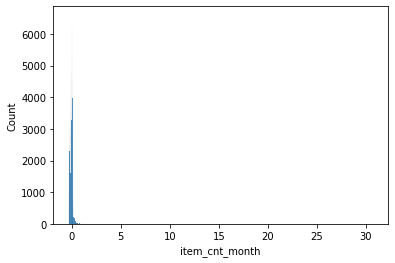

In [190]:
sns.histplot(dfTest['item_cnt_month'])

## Analysis and Results

* The Kaggle Score for test data is 1.18078
   * I assume that is RMSE on test data which is similar to what I had on train
   * This puts me in the mid place on the leaderboard


* What went well
    * The general idea of the LSTM model showed promise for this problem
    * The scaled RMSE on the training data was very low
    * The training time over this very large model using a notebook with 30 GB of RAM and 8 cores was approximately 1 day

* What can be improved
   * A deeper network would improve performance
   * Using more epochs could improve performance. We limited our model to 20 epochs and used an early stop to cut that off if loss didn't improve in 3 epochs
   * The biggest issue is with feature value clustering and imputing values
   * We could improve the model by using unsupervised techniques to cluster items and shops
   * The items include categories that have some value but we need additional clustering
   * The item clusters are things such as Games - Xbox, Accessories - Xbox, Games - PS4 and various book, music, and video categories
   * These could help with imputing missing values in the test and training data
   * An issue with this type of data is that many of these items come out on a certain date, have a spike, then fade
   * To properly trend items we need to track trends on a few axis
   * Some of this could include natural language proceessing. 
   * For example, if we have data on the sales for the release month of 2 different Call of Duty games and we have new Call of Duty game in the test data, we can assume it will have similar results
   * In another example, if the release date of a game on Xbox was in November but was in December for PS4, we could use the Xbox data, scaled by platform popularity to estimate the value for the PS4 version.


## References
* https://www.tutorialspoint.com/time_series/time_series_lstm_model.htm
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://stackoverflow.com/questions/41233635/meaning-of-inter-op-parallelism-threads-and-intra-op-parallelism-threads
